# **Fashion MNIST Image Classification Using CNN with PyTorch**

In this project, we will classify Fashion-MNIST dataset using Convolutional Neural Networks with PyTorch.</p>

## Import Necessary Libraries

In [1]:
import torch 
import numpy as np
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

torch.manual_seed(0)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU:", torch.cuda.get_device_name(0))

GPU: NVIDIA GeForce GTX 1660 SUPER


In [3]:
# Function for showing the image
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy(), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

## Prepare Dataset

Use `Compose` to create a transform to resize the image and convert it to a tensor

In [4]:
composed = transforms.Compose([transforms.ToTensor()])

Create two dataset objects for the Fashion MNIST  dataset. One for training data called `dataset_train` and one for validation data `dataset_val`

In [5]:
dataset_train = dsets.FashionMNIST(root= '.fashion/data', train=True, transform=composed, download=True)
dataset_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: .fashion/data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
dataset_val = dsets.FashionMNIST(root= '.fashion/data', train=False, transform=composed, download=True)
dataset_val

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: .fashion/data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

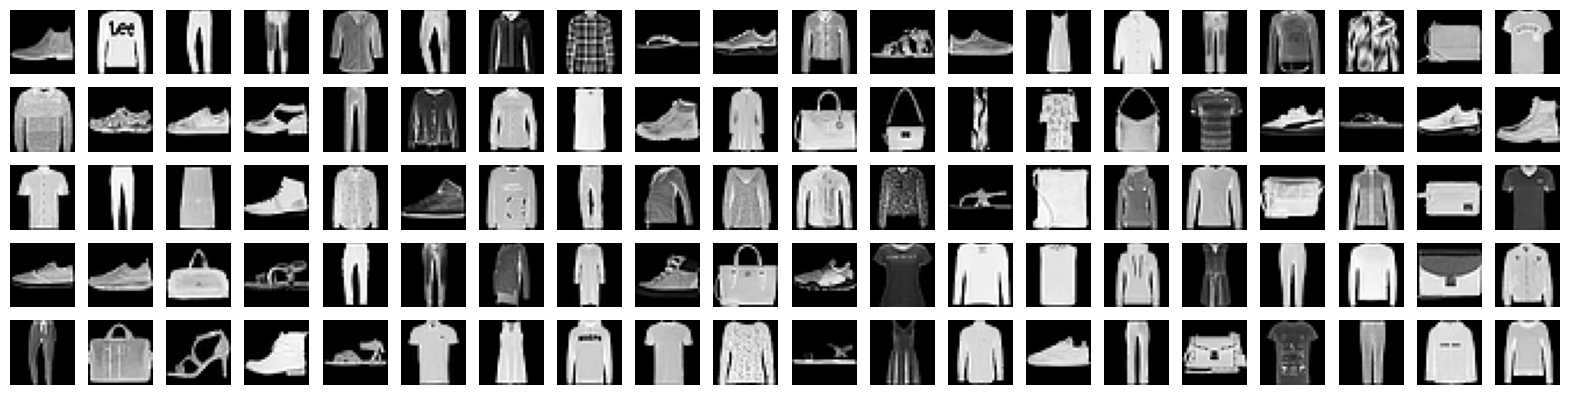

In [7]:
plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(20, 20, i+1)
    plt.imshow(dataset_val[i][0].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

## Create Convolutional Neural Network Class

Constructor  for regular Convolutional Neural Network

In [8]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1, out_2, number_of_classes):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(out_2*6*6, 600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, number_of_classes)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.drop(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)

        return x

Train loader  and validation loader 

In [9]:
train_loader = DataLoader(dataset=dataset_train, batch_size=100)
test_loader = DataLoader(dataset=dataset_val, batch_size=100)

Creating a model for CNN class

In [10]:
model = CNN(out_1=32, out_2=64,number_of_classes=10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
print(model)

CNN(
  (cnn1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


## Model Training

In [11]:
train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

N_test = len(dataset_val)
n_epochs = 20

# Train the model
for epoch in range(n_epochs):
    train_loss = 0
    correct_train = 0
    model.train()
    for x_train, y_train in train_loader:
        optimizer.zero_grad()
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        z_train = model(x_train)
        loss_train = criterion(z_train, y_train)
        loss_train.backward()
        optimizer.step()
        train_loss += loss_train.item()
        _, yhat_train = torch.max(z_train.data, 1)
        correct_train += (yhat_train == y_train).sum().item()
    
    train_accuracy = correct_train / len(dataset_train)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    val_loss = 0
    correct_val = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            z_val = model(x_val)
            loss_val = criterion(z_val, y_val)
            val_loss += loss_val.item()
            _, yhat_val = torch.max(z_val.data, 1)
            correct_val += (yhat_val == y_val).sum().item()
    
    val_accuracy = correct_val / N_test
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)

## Model Evaluation

Plot cost and accuracy

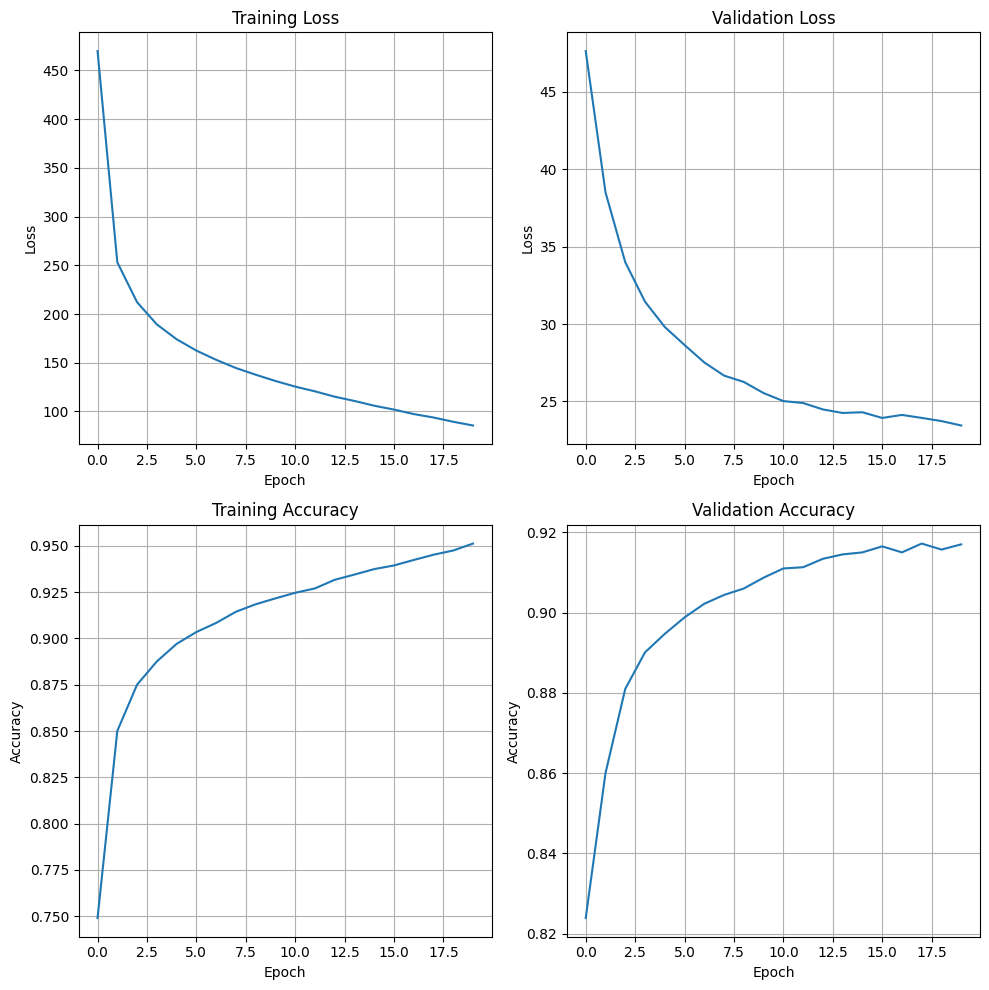

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot training loss
axs[0, 0].plot(train_loss_list, label='Training Loss')
axs[0, 0].set_title('Training Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)

# Plot validation loss
axs[0, 1].plot(val_loss_list, label='Validation Loss')
axs[0, 1].set_title('Validation Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)

# Plot training accuracy
axs[1, 0].plot(train_accuracy_list, label='Training Accuracy')
axs[1, 0].set_title('Training Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].grid(True)

# Plot validation accuracy
axs[1, 1].plot(val_accuracy_list, label='Validation Accuracy')
axs[1, 1].set_title('Validation Accuracy')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

Print classification report

In [13]:
model.eval()
y_pred = []
y_true = []

for x_test, y_test in test_loader:
    x_test = x_test.to(device)
    z = model(x_test)
    _, yhat = torch.max(z.data, 1)
    y_pred.extend(yhat.cpu().numpy())
    y_true.extend(y_test.cpu().numpy())

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1000
           1       0.99      0.97      0.98      1000
           2       0.87      0.88      0.87      1000
           3       0.89      0.95      0.92      1000
           4       0.88      0.86      0.87      1000
           5       0.99      0.97      0.98      1000
           6       0.79      0.73      0.76      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



Display confusion matrix

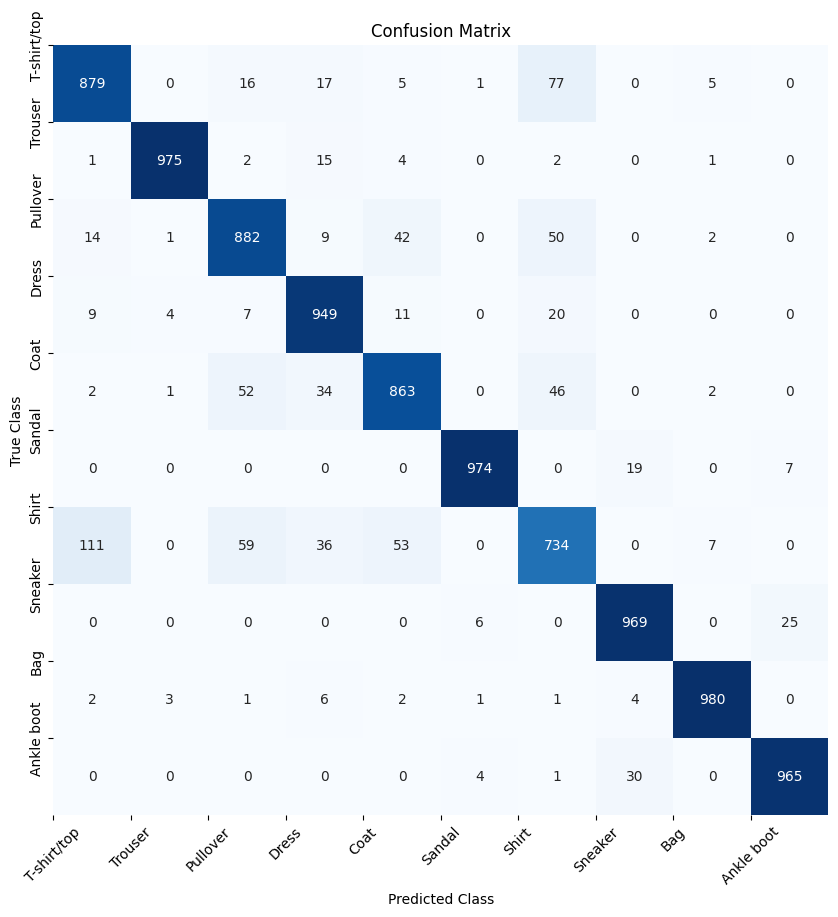

In [14]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')

# Set x and y axis ticks and labels
tick_marks = np.arange(len(dataset_val.classes))
plt.xticks(tick_marks, dataset_val.classes, rotation=45)
plt.yticks(tick_marks, dataset_val.classes)

plt.show()

## Export Trained Model

In [15]:
# Export Trained Model
torch.save(model, 'models/fashion_cnn_pytorch.pt')